In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

from keras import backend as K
K.set_image_data_format('channels_first')

C:\Users\Vince\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Training data

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np

# define function to load train, test, and validation datasets
def load_dataset(path):
    num_classes = len(list(os.scandir(path)))
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), num_classes)
    return files, targets

FILES_DIR = os.path.abspath("D:\\Data\\Dermatology\\train")
train_files, ytrain = load_dataset(FILES_DIR)

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

ksize = 5
scalar = 0.4
ROWS = int(128 * scalar)
COLS = int(96 * scalar)

CHANNELS = 3

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(ROWS, COLS))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
xtrain = paths_to_tensor(train_files).astype('float32')/255

100%|██████████████████████████████████████| 2000/2000 [10:53<00:00,  3.06it/s]


In [4]:
# Not currently needed; we have our validation data in a separate folder already

# from sklearn.model_selection import train_test_split

# xtrain, xtest, ytrain, ytest = train_test_split(train_tensors, train_targets, test_size=0.1)

# Make sure to edit the NN so that
# input_shape=(ROWS, COLS, CHANNELS) is accurate
xtrain.shape

(2000, 3, 51, 38)

# Validation data

In [5]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    num_classes = len(list(os.scandir(path)))
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), num_classes)
    return files, targets

FILES_DIR = os.path.abspath("D:\\Data\\Dermatology\\valid")
valid_files, yval = load_dataset(FILES_DIR)

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

# ksize = 5
# ROWS = 128
# COLS = 96

# CHANNELS = 3

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(ROWS, COLS))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
xval = paths_to_tensor(valid_files).astype('float32')/255

100%|████████████████████████████████████████| 150/150 [01:54<00:00,  1.31it/s]


# Standard CNN

A pretty run-of-the-mill CNN that uses convolutions and max pooling. Performs poorly.

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D

rlr = ReduceLROnPlateau(factor=.01, patience=2)
es = EarlyStopping(monitor='val_acc', patience=0)


model = Sequential()

model.add(Convolution2D(32, kernel_size=(ksize, ksize), padding='same',
                        input_shape=(CHANNELS, ROWS, COLS),
                        activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(64, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(64, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(128, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(256, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first",))

model.add(Flatten())

model.add(Dense(3072, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))


model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 51, 38)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 51, 38)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 25, 19)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 25, 19)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 12, 9)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 12, 9)        204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 6, 4)         0         
__________

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(xtrain, ytrain, epochs=200, batch_size=128,
          callbacks=[es, rlr], validation_data=(xval, yval), verbose=0)

loss, acc = model.evaluate(xval, yval)

acc

150/150 [==============================] - ETA: 0s - ETA: 0s - 0s 1ms/step


0.5199999984105428

# VGG

In [11]:
from keras.layers import GlobalAveragePooling2D

model = Sequential()

model.add(Convolution2D(64, kernel_size=(ksize, ksize), padding='same',
                        input_shape=(CHANNELS, ROWS, COLS),
                        activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(64, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(128, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(128, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(128, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(256, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(256, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))
# model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

# if i == True:
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 51, 38)        4864      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 51, 38)        102464    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 25, 19)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 25, 19)       204928    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 25, 19)       409728    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 12, 9)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 12, 9)        409728    
__________

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(xtrain, ytrain, epochs=200, batch_size=128,
          callbacks=[es, rlr], validation_data=(xval, yval), verbose=0)

loss, acc = model.evaluate(xval, yval)

acc

150/150 [==============================] - ETA: 1s - ETA: 0s - ETA: 0s - ETA: 0s - 1s 4ms/step


0.5199999984105428

# VGG with center normalizing

In [15]:
from keras.layers import Activation

def center_normalize(x):
    return (x-K.mean(x))/K.std(x)

model=Sequential()
model.add(Activation(activation=center_normalize, input_shape=(CHANNELS, ROWS, COLS),))

model.add(Convolution2D(64, kernel_size=(ksize, ksize), padding='same',
                        input_shape=(CHANNELS, ROWS, COLS),
                        activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(64, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(128, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(128, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(128, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(256, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(256, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))


model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(Convolution2D(512, kernel_size=(ksize, ksize), padding='same', activation='relu',
                        data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=[2,2], data_format="channels_first"))
# model.add(GlobalAveragePooling2D())

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

# if i == True:
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_7 (Activation)    (None, 3, 64, 48)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 48)        4864      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 48)        102464    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 32, 24)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 32, 24)       204928    
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 32, 24)       409728    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 128, 16, 12)       0         
__________

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(xtrain, ytrain, epochs=200, batch_size=16,
          callbacks=[es, rlr], validation_data=(xval, yval), verbose=0)

loss, acc = model.evaluate(xval, yval)

acc

150/150 [==============================] - ETA: 0s - ETA: 0s - ETA: 0s - ETA: 0s - 1s 4ms/step


0.5199999984105428

# Others

## 2 layer

In [13]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

rlr = ReduceLROnPlateau(factor=.01, patience=2)
es = EarlyStopping(monitor='val_acc', patience=5)


adam = Optimizer=Adam(lr=0.001)

def center_normalize(x):
    return (x-K.mean(x))/K.std(x)

model=Sequential()
model.add(Activation(activation=center_normalize, input_shape=(CHANNELS, ROWS, COLS),))

model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))

model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='sigmoid'))


model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(xtrain, ytrain, epochs=200, batch_size=64,
          callbacks=[es, rlr], validation_data=(xval, yval), verbose=0)

loss, acc = model.evaluate(xval, yval)

acc

150/150 [==============================] - ETA: 0s - 0s 286us/step


0.7511111442248026

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

rlr = ReduceLROnPlateau(factor=.01, patience=2)
es = EarlyStopping(monitor='val_acc', patience=5)


adam = Optimizer=Adam(lr=0.001)

def center_normalize(x):
    return (x-K.mean(x))/K.std(x)

model=Sequential()
model.add(Activation(activation=center_normalize, input_shape=(CHANNELS, ROWS, COLS),))

# convolutional layer
model.add(Convolution2D(16, kernel_size=(ksize, ksize), activation='relu',
                        data_format='channels_first', padding='same'))
#pooling layer
model.add(MaxPooling2D(pool_size=(2,2), data_format='channels_first'))

model.add(Flatten())

model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='sigmoid'))


model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(xtrain, ytrain, epochs=200, batch_size=64,
          callbacks=[es, rlr], validation_data=(xval, yval), verbose=0)

loss, acc = model.evaluate(xval, yval)

acc

150/150 [==============================] - ETA: 0s - 0s 320us/step


0.7422222526868184

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

rlr = ReduceLROnPlateau(factor=.01, patience=2)
es = EarlyStopping(monitor='val_acc', patience=5)


adam = Optimizer=Adam(lr=0.001)

def center_normalize(x):
    return (x-K.mean(x))/K.std(x)

model=Sequential()
model.add(Activation(activation=center_normalize, input_shape=(CHANNELS, ROWS, COLS),))

# convolutional layer
model.add(Convolution2D(16, kernel_size=(ksize, ksize), activation='relu',
                        data_format='channels_first', padding='same'))
#pooling layer
model.add(MaxPooling2D(pool_size=(2,2), data_format='channels_first'))

# convolutional layer
model.add(Convolution2D(32, kernel_size=(ksize, ksize), activation='relu',
                        data_format='channels_first', padding='same'))
#pooling layer
model.add(MaxPooling2D(pool_size=(2,2), data_format='channels_first'))

model.add(Flatten())

# Relu 
model.add(Dense(2048, activation='relu'))

model.add(Dense(128, activation='relu'))


model.add(Dense(3))

model.summary()
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(xtrain, ytrain, epochs=200, batch_size=64,
          callbacks=[es, rlr], validation_data=(xval, yval), verbose=0)

loss, acc = model.evaluate(xval, yval)

acc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_9 (Activation)    (None, 3, 51, 38)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 51, 38)        1216      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 25, 19)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 25, 19)        12832     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 12, 9)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 2048)              7079936   
__________

In [20]:
# yval_binary = np.where(np.argmax(yval, axis=1) == 1, 0, 1)

# How to predict a single image

Just for illustrative purposes, I grabbed an image from the training set.

In [10]:
img = os.path.abspath("D:\\Data\\Dermatology\\train\\nevus\\ISIC_0000001.jpg")

In [13]:
from tqdm import tqdm

ksize = 5
scalar = 0.5
ROWS = int(128 * scalar)
COLS = int(96 * scalar)

CHANNELS = 3

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(ROWS, COLS))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img):
    list_of_tensors = [path_to_tensor(img)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
img = paths_to_tensor(img).astype('float32')/255

In [14]:
xtrain.shape

(1, 3, 64, 48)

In [15]:
# It trained on this image, so don't take the predictions as an
# indication of the model's accuracy.
model.predict_proba(img)

array([[6.806889e-05, 9.999280e-01, 3.877733e-06]], dtype=float32)

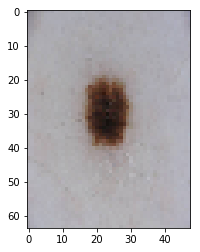

In [17]:
# Show image

image = np.squeeze(img)
image = np.swapaxes(image, 0, 1)
image = np.swapaxes(image, 2, 1)
nev = plt.imshow(image)
plt.show()